# Лабораторна робота &numero;3. Дерева прийняття рішень.

In [0]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import graphviz as gv
import numpy as np

from typing import Literal
from sklearn.metrics import (recall_score, matthews_corrcoef, precision_score,
                             accuracy_score, f1_score, balanced_accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [0]:
COLORS = ['#00a876', '#edb724']
plt.rcParams['font.family'] = 'Century Gothic'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.title_fontsize'] = 24
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.facecolor'] = '#e3f3fc'

METRICS = {
    accuracy_score: 'Accuracy',
    precision_score: 'Precision',
    recall_score: 'Recall',
    matthews_corrcoef: 'MCC',
    f1_score: 'F1 score',
    balanced_accuracy_score: 'Bal. accuracy'
}

1. Відкрити та зчитати наданий файл з даними.
2. Визначити та вивести кількість записів та кількість полів у завантаженому наборі даних.
3. Вивести перші 10 записів набору даних.

In [0]:
def open_file():
    with open('./dataset_2.txt', 'r', encoding='utf8') as file:
        content = file.read()
    n_params = content.count(',', 0, content.index('\n'))
    params = ','.join(f'f{i}' for i in range(1, n_params - 1))

    with io.StringIO(f'id,date,{params},c\n' + content) as buffer:
        buffer.seek(0)
        df = pd.read_csv(buffer).set_index('id')
    return df


df = open_file()
print(f'{len(df)} записів, {len(df.columns)} полів')
df.head(10)

8143 записів, 7 полів


,date,f1,f2,f3,f4,f5,c
id,,,,,,,
1,2015-02-04 17:51:00,23.180,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.150,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.150,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.150,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.100,27.2000,426.0,704.500000,0.004757,1
6,2015-02-04 17:55:59,23.100,27.2000,419.0,701.000000,0.004757,1
7,2015-02-04 17:57:00,23.100,27.2000,419.0,701.666667,0.004757,1
8,2015-02-04 17:57:59,23.100,27.2000,419.0,699.000000,0.004757,1
9,2015-02-04 17:58:59,23.100,27.2000,419.0,689.333333,0.004757,1


4. Розділити набір даних на навчальну (тренувальну) та тестову вибірки.

In [0]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    df[df.columns.difference(('c', 'date'))],
    df[['c']],
    test_size=0.25
)
print(f'Тренувальна вибірка: {len(X_TRAIN)} записів')
print(f'Тестова вибірка:     {len(X_TEST)} записів')

Тренувальна вибірка: 6107 записів
Тестова вибірка:     2036 записів


5. Використовуючи відповідні функції бібліотеки scikit-learn, збудувати класифікаційну модель дерева прийняття рішень глибини 5 та навчити її на тренувальній вибірці, вважаючи, що в наданому наборі даних цільова характеристика визначається останнім стовпчиком, а всі інші (окрім двох перших) виступають в ролі вихідних аргументів.

In [0]:
class Model(DecisionTreeClassifier):
    def graph(self, width=12, height=9, filled=True, rounded=True,
              fontname='Consolas'):

        return gv.Source(export_graphviz(
            self, filled=filled, rounded=rounded, fontname=fontname
        ).replace('{', f'{{\nsize="{width},{height}!"', 1))

    def calculate_metrics(self, x_test, y_true):
        y_pred = self.predict(x_test)
        return {
            'id': [*METRICS.values()],
            'value': [metric(y_true, y_pred) for metric in METRICS]
        }

In [0]:
model_enth = Model(criterion='entropy', max_depth=5)
model_enth.fit(X_TRAIN, Y_TRAIN)

model_gini = Model(criterion='gini', max_depth=5)
model_gini.fit(X_TRAIN, Y_TRAIN)
None

6. Представити графічно побудоване дерево за допомогою бібліотеки graphviz.

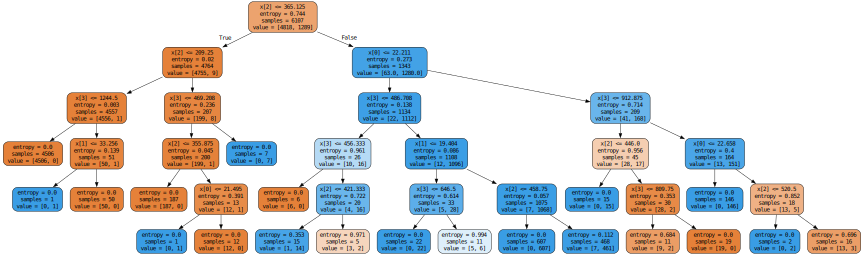

In [0]:
model_enth.graph()

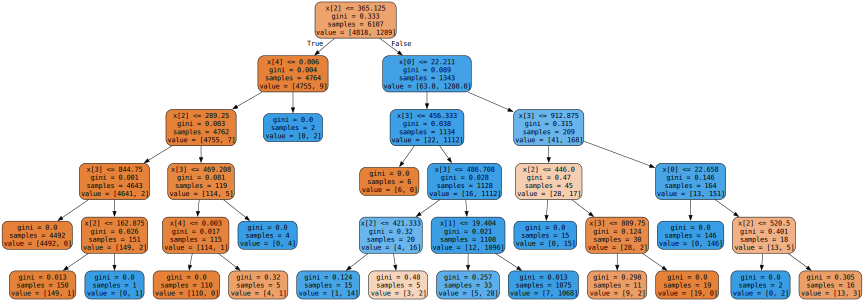

In [0]:
model_gini.graph()

7. Обчислити класифікаційні метрики збудованої моделі для тренувальної та тестової вибірки. Представити результати роботи моделі на тестовій вибірці графічно. Порівняти результати, отриманні при застосуванні різних критеріїв розщеплення: інформаційний приріст на основі ентропії чи неоднорідності Джині.

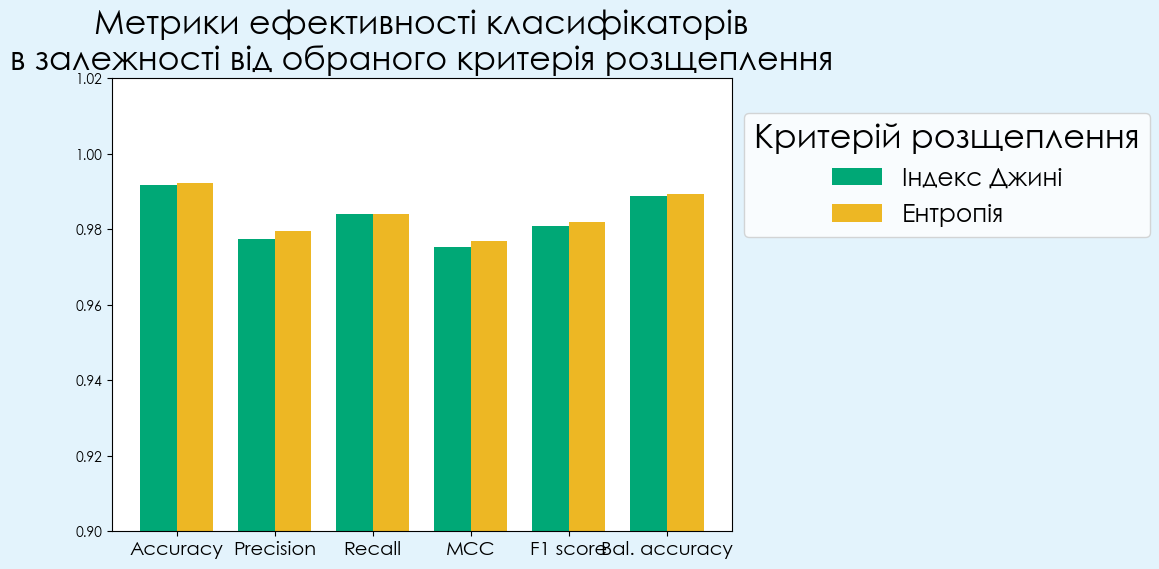

In [0]:
def plot_metrics():
    metrics = model_enth.calculate_metrics(X_TEST, Y_TEST)
    metrics['v_enth'] = metrics['value']
    metrics['v_gini'] = model_gini.calculate_metrics(X_TEST, Y_TEST)['value']

    width = 0.375
    x = np.arange(len(metrics['id']))
    ax = plt.subplot()

    legend = ax.legend(
        handles=[
            ax.bar(x - width/2, metrics['v_gini'], width, color=COLORS[0]),
            ax.bar(x + width/2, metrics['v_enth'], width, color=COLORS[1])
        ],
        labels=['Індекс Джині', 'Ентропія'],
        loc=(1.02, 0.65)
    )
    legend.set_title('Критерій розщеплення')
    ax.set_title('Метрики ефективності класифікаторів\n'
                 'в залежності від обраного критерія розщеплення')
    ax.set_ylim(0.9, 1.02)
    ax.set_xticks(x, metrics['id'], size=14)


plot_metrics()

8. З’ясувати вплив максимальної кількості листів та мінімальної кількості елементів в листі дерева на результати класифікації. Результати представити графічно.

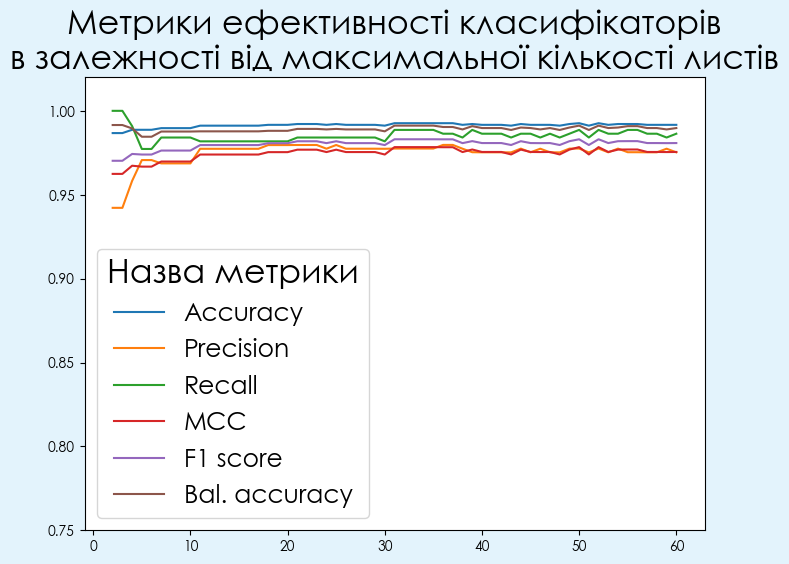

In [0]:
def max_leafcount_impact(criterion: Literal['gini', 'entropy'],
                         x_train: list,
                         y_train: list,
                         x_test: list,
                         y_test: list,
                         mx: int
                         ):
    assert mx >= 2, 'Maximum leaf count should be bigger than 2'

    X = [*range(2, mx + 1)]
    data = {'count': X} | {name: [] for name in METRICS.values()}
    for i in X:
        y_pred = Model(criterion=criterion, max_leaf_nodes=i)\
            .fit(x_train, y_train)\
            .predict(x_test)

        for metric, name in METRICS.items():
            data[name].append(metric(y_test, y_pred))

    ax = plt.subplot()
    [ax.plot(X, data[label], label=label) for label in METRICS.values()]
    ax.legend(title='Назва метрики')
    ax.set_ylim(0.75, 1.02)
    ax.set_title('Метрики ефективності класифікаторів\n'
                 'в залежності від максимальної кількості листів',
                 size=24)


max_leafcount_impact(criterion='entropy',
                     x_train=X_TRAIN,
                     y_train=Y_TRAIN,
                     x_test=X_TEST,
                     y_test=Y_TEST,
                     mx=60)

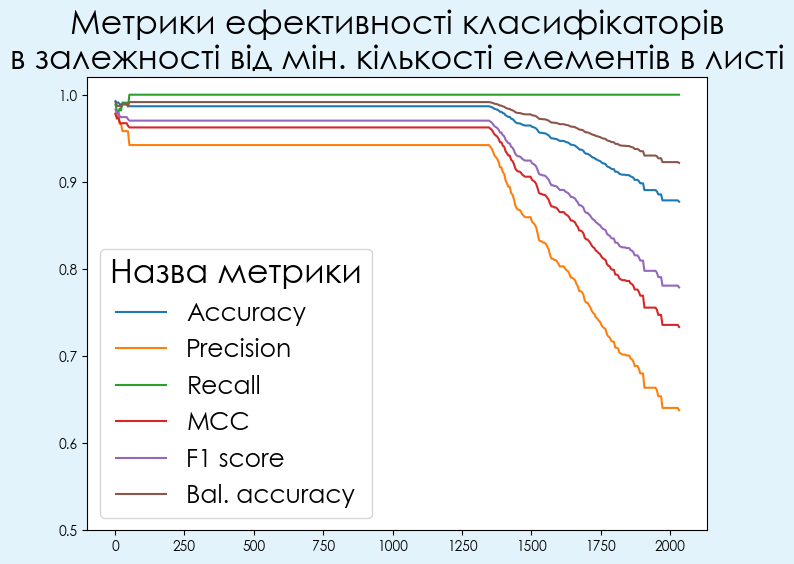

In [0]:
def min_elemcount_impact(criterion: Literal['gini', 'entropy'],
                         x_train: list,
                         y_train: list,
                         x_test: list,
                         y_test: list,
                         mx: int
                         ):
    assert mx <= len(y_train),\
        'Maximum element count should be less than dataset size'

    X = [*range(2, mx + 1, 5)]
    data = {
        'count': X,
        **{name: [] for name in METRICS.values()}
    }

    for i in X:
        y_pred = Model(criterion=criterion, min_samples_leaf=i)\
            .fit(x_train, y_train)\
            .predict(x_test)

        for metric, name in METRICS.items():
            data[name].append(metric(y_test, y_pred))

    ax = plt.subplot()
    [ax.plot(X, data[label], label=label) for label in METRICS.values()]
    ax.legend(title='Назва метрики')
    ax.set_ylim(0.5, 1.02)
    ax.set_title('Метрики ефективності класифікаторів\n'
                 'в залежності від мін. кількості елементів в листі',
                 size=24)

min_elemcount_impact(criterion='gini',
                     x_train=X_TRAIN,
                     y_train=Y_TRAIN,
                     x_test=X_TEST,
                     y_test=Y_TEST,
                     mx=len(X_TRAIN) // 3)

9. Навести стовпчикову діаграму важливості атрибутів, які використовувалися для класифікації ( див. `feature_importances_`).
Пояснити, яким чином – на Вашу думку – цю важливість можна підрахувати.

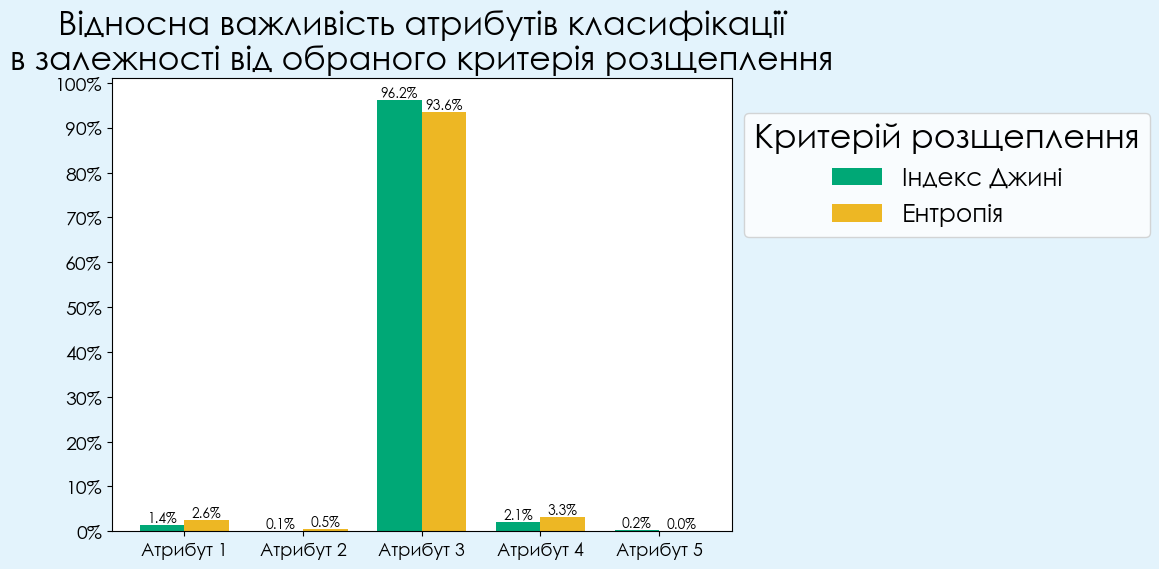

In [0]:
def importances():
    width = 0.375
    x = np.arange(len(df.columns.difference(['date', 'c'])))
    data = {
        'gini': model_gini.feature_importances_ * 100,
        'enth': model_enth.feature_importances_ * 100
    }

    ax = plt.subplot()
    legend = ax.legend(
        [
            ax.bar(x - width/2, data['gini'], width, color=COLORS[0]),
            ax.bar(x + width/2, data['enth'], width, color=COLORS[1])
        ],
        ['Індекс Джині', 'Ентропія'],
        loc=(1.02, 0.65)
    )
    [
        ax.text(xi + dx, hi, f"{hi:.1f}%", ha="center", va="bottom")
        for name, dx in [('gini', -width/2), ('enth', width/2)]
        for xi, hi in zip(x, data[name])
    ]
    legend.set_title('Критерій розщеплення')
    ax.set_title('Відносна важливість атрибутів класифікації\n'
                 'в залежності від обраного критерія розщеплення')
    ax.set_xticks(x, [f'Атрибут {xi + 1}' for xi in x], size=13)
    ax.set_yticks(range(0, 101, 10))
    ax.set_yticklabels(map("{:.0f}%".format, range(0, 101, 10)), size=14)

importances()